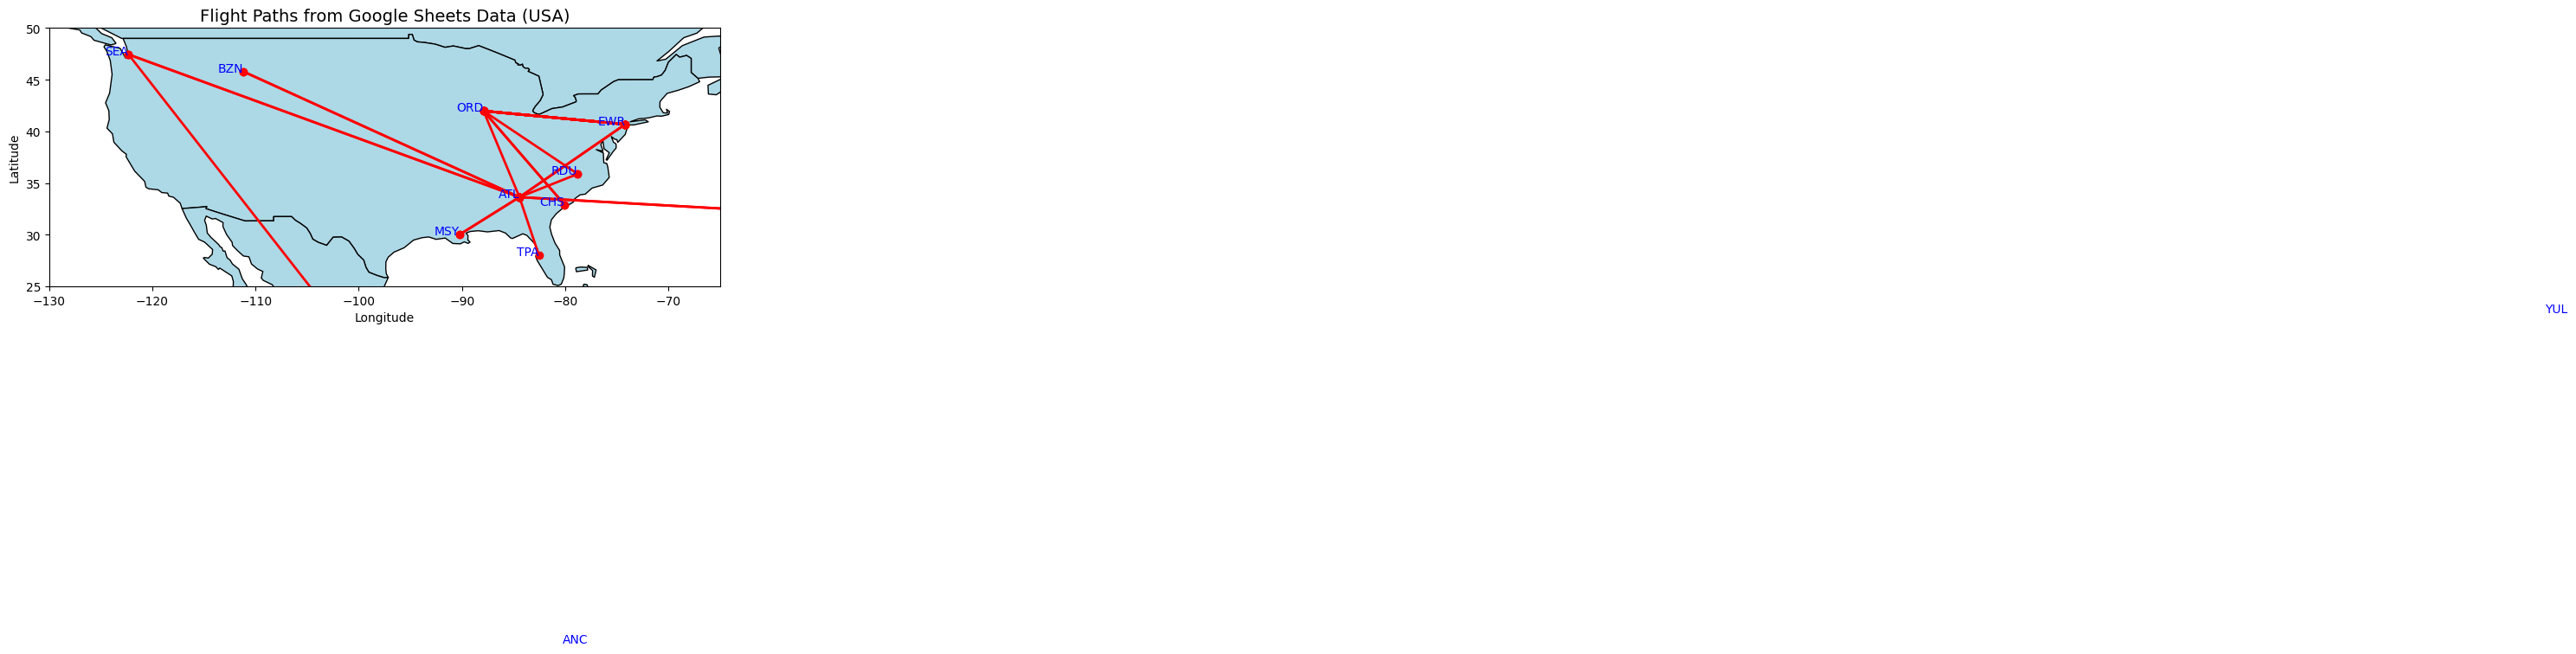

In [3]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import pandas as pd
import plotly.graph_objects as go
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

# Step 1: Authenticate and connect to Google Sheets
scope = ["https://spreadsheets.google.com/feeds", "https://www.googleapis.com/auth/drive"]
creds = ServiceAccountCredentials.from_json_keyfile_name('your_google_creds.json', scope)
client = gspread.authorize(creds)
sheet = client.open("2024 Flights").sheet1

# Step 2: Get all the data from the sheet
data = sheet.get_all_records()
df = pd.DataFrame(data)

# Step 3: Geocoding airports to latitude and longitude
geolocator = Nominatim(user_agent="flight_visualization")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
airports = pd.Series(df['Departure Airport'].tolist() + df['Arrival Airport'].tolist()).unique()

airport_locations = {}
for airport in airports:
    location = geocode(airport)
    if location:
        airport_locations[airport] = (location.latitude, location.longitude)

# Step 4: Create an interactive map with Plotly
fig = go.Figure()

# Add flight paths to the map
for i in range(len(df)):
    dep_airport = df.iloc[i]["Departure Airport"]
    arr_airport = df.iloc[i]["Arrival Airport"]

    if dep_airport in airport_locations and arr_airport in airport_locations:
        dep_location = airport_locations[dep_airport]
        arr_location = airport_locations[arr_airport]

        fig.add_trace(go.Scattergeo(
            locationmode='USA-states',
            lon=[dep_location[1], arr_location[1]],
            lat=[dep_location[0], arr_location[0]],
            mode='lines',
            line=dict(width=2, color='red'),
        ))

# Update layout to focus on the USA
fig.update_layout(
    title_text='Flight Paths from Google Sheets Data (USA)',
    geo=dict(
        scope='usa',
        projection_type='albers usa',
        showland=True,
        landcolor="lightblue",
    ),
)

# Save the map as an HTML file
fig.write_html("flight_paths_map.html")
